<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [85]:
# installs.
!python -m spacy download en_core_web_lg
!pip install --upgrade pip
!pip install pyLDAvis

# imports.
import pandas as pd
import numpy as np
import seaborn as sns 
import gensim
import os
import re
import spacy 
import pyLDAvis.gensim
from spacy.tokenizer import Tokenizer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
# read in the csv file.
link = 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
df = pd.read_csv(link)

In [142]:
# show the dataframe shape.
print (df.shape)
# show the data frame with headers.
df.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [88]:
# show the dataframe types.
df.dtypes

id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateSeen        object
reviews.didPurchase     object
reviews.doRecommend     object
reviews.id             float64
reviews.numHelpful     float64
reviews.rating           int64
reviews.sourceURLs      object
reviews.text            object
reviews.title           object
reviews.username        object
sourceURLs              object
dtype: object

In [89]:
# check if there are any NA's.
df.isna().sum()

id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              0
reviews.username           0
sourceURLs                 0
dtype: int64

In [90]:
# check the metrics for the #'s.
df.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,4.100000e+01,16115.000000,28332.000000
mean,1.840066e+08,0.529321,4.514048
std,2.337036e+07,9.345017,0.934957
min,1.116244e+08,0.000000,1.000000
25%,1.843344e+08,0.000000,4.000000
50%,1.885078e+08,0.000000,5.000000
75%,1.988160e+08,0.000000,5.000000
max,2.085304e+08,621.000000,5.000000


In [91]:
# heck the metrics for non #'s.
df.describe(include='all')

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
count,28332,28332,28332,28332,28332,28332,28332,28332,28332,28332,28332,28332,28332,28332,9,16086,4.100000e+01,16115.000000,28332.000000,28332,28332,28332,28332,28332
unique,65,55,52,65,65,3,60,9,65,65,4,65,1313,606,2,2,NaN,NaN,NaN,9906,18168,10441,16269,65
top,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazon,"AA,AAA,Health,Electronics,Health & Household,C...",Electronics,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",Amazon,HL-002619,2017-01-23T00:00:00.000Z,2017-08-28T00:00:00Z,True,True,NaN,NaN,NaN,https://www.amazon.com/product-reviews/B00QWO9...,good,Five Stars,ByAmazon Customer,"https://www.barcodable.com/upc/841710106442,ht..."
freq,8343,8343,8343,8343,8343,16153,8343,13995,8343,8343,16130,8343,532,8343,8,15353,NaN,NaN,NaN,12071,60,3937,889,8343
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.840066e+08,0.529321,4.514048,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337036e+07,9.345017,0.934957,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.116244e+08,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.843344e+08,0.000000,4.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.885078e+08,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.988160e+08,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN


In [92]:
df['reviews.text'][:20]

0     I order 3 of them and one of the item is bad q...
1     Bulk is always the less expensive way to go fo...
2     Well they are not Duracell but for the price i...
3     Seem to work as well as name brand batteries a...
4     These batteries are very long lasting the pric...
5     Bought a lot of batteries for Christmas and th...
6     ive not had any problame with these batteries ...
7     Well if you are looking for cheap non-recharge...
8     These do not hold the amount of high power jui...
9     AmazonBasics AA AAA batteries have done well b...
10    I find amazon basics batteries to be equal if ...
11    When I first started getting the Amazon basic ...
12    Use it for my fish tank's light at night and w...
13    just got em so I can't really comment on how g...
14    we have many things that need aa battery they ...
15    Thankful that I was able to find on Amazon for...
16    I don't know if I would buy thus brand again s...
17    In my opinion these did not last anywhere 

In [143]:
# clean the reviews.text column with lambda functions and regex.

# keep only letters and numbers.
df['reviews.text'] = df['reviews.text'].apply(lambda x: re.sub(r'[^a-zA-Z ^0-9]', '', x))
df['reviews.title'] = df['reviews.title'].apply(lambda x: re.sub(r'[^a-zA-Z ^0-9]', '', x))
# convert  the text to lowercase.
df['reviews.text'] = df['reviews.text'].apply(lambda x: x.lower())
df['reviews.title'] = df['reviews.title'].apply(lambda x: x.lower())

# show the dataframe with headers.
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,i order 3 of them and one of the item is bad q...,3 of them and one of the item is bad quality ...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,bulk is always the less expensive way to go fo...,always the less expensive way to go for produ...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,well they are not duracell but for the price i...,are not duracell but for the price i am happy,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,seem to work as well as name brand batteries a...,as well as name brand batteries at a much better,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,these batteries are very long lasting the pric...,batteries are very long lasting the price is ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [144]:
# check example.
df['reviews.text'][5]

'bought a lot of batteries for christmas and the amazonbasics cell have been good i havent noticed a difference between the brand name batteries and the amazon basic brand just a lot easier to purchase and have arrive at the house and have on hand will buy again'

In [0]:
# set the nlp with "en_core_web_lg" file.
nlp = spacy.load("en_core_web_lg")
# set the tokenizer on nlp.vocab.
tokenizer = Tokenizer(nlp.vocab)

In [0]:
# set the default stop words.
STOP_WORDS = nlp.Defaults.stop_words

In [146]:
# tokenizer pipeline for reviews.text removing stop words, blank words and lemmatizing.
tokens = []

for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    for token in doc:
        if (token.lemma_ not in STOP_WORDS) & (token.text != ' '):
            doc_tokens.append(token.lemma_)

    tokens.append(doc_tokens)
    
# set the new tokens in the data frame.
df['reviews.text'] = tokens
# show the data frame tokens.
df['reviews.text'].head()

0    [order, 3, item, bad, quality, miss, backup, s...
1        [bulk, little, expensive, way, product, like]
2                       [good, duracell, price, happy]
3                  [work, good, brand, battery, price]
4                        [battery, long, price, great]
Name: reviews.text, dtype: object

In [98]:
# tokenizer pipeline for reviews.title removing stop words, blank words and lemmatizing.
tokens = []

for doc in tokenizer.pipe(df['reviews.title'], batch_size=500):
    
    doc_tokens = []
    for token in doc:
        if (token.lemma_ not in STOP_WORDS) & (token.text != ' '):
            doc_tokens.append(token.lemma_)

    tokens.append(doc_tokens)
    
# set the new tokens in the data frame.
df['reviews.title'] = tokens
# show the data frame tokens.
df['reviews.title'].head()

0    [3, item, bad, quality, miss, backup, spring]
1          [little, expensive, way, product, like]
2                         [duracell, price, happy]
3                           [good, brand, battery]
4                    [battery, long, price, great]
Name: reviews.title, dtype: object

In [147]:
# check the column has been tokenized.
df['reviews.text'][5]

['buy',
 'lot',
 'battery',
 'christmas',
 'amazonbasics',
 'cell',
 'good',
 'havent',
 'notice',
 'difference',
 'brand',
 'battery',
 'amazon',
 'basic',
 'brand',
 'lot',
 'easy',
 'purchase',
 'arrive',
 'house',
 'hand',
 'buy']

In [0]:
# set the dictionary representation of all the words in our corpus.
id2word = corpora.Dictionary(df['reviews.text'])

In [102]:
# check a word count.
id2word.token2id['good']

19

In [103]:
# check the length of the dictionary.
len(id2word.keys())

10128

In [0]:
# remove extreme values from the dataset.
id2word.filter_extremes(no_below=5, no_above=0.95)

In [105]:
# check the length of the dictionary.
len(id2word.keys())

2842

In [0]:
# create bag of words(bow) representation of our corpus.
corpus = [id2word.doc2bow(text) for text in df['reviews.text']]

In [107]:
# show the top 10 in corpus.
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [108]:
# create the lda multicore pipeline.
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [109]:
# show the topics generated from the pipeline.
lda.print_topics()

[(0,
  '0.035*"amazon" + 0.027*"use" + 0.026*"great" + 0.024*"tablet" + 0.016*"fire" + 0.016*"music" + 0.014*"prime" + 0.014*"good" + 0.013*"app" + 0.013*"device"'),
 (1,
  '0.038*"great" + 0.038*"tablet" + 0.029*"good" + 0.027*"screen" + 0.020*"use" + 0.017*"card" + 0.015*"quality" + 0.014*"memory" + 0.013*"work" + 0.012*"fast"'),
 (2,
  '0.055*"battery" + 0.034*"charge" + 0.022*"cant" + 0.022*"thank" + 0.018*"cheap" + 0.017*"amazon" + 0.016*"item" + 0.015*"time" + 0.015*"beat" + 0.014*"describe"'),
 (3,
  '0.065*"tablet" + 0.041*"love" + 0.031*"great" + 0.028*"use" + 0.027*"watch" + 0.027*"read" + 0.026*"book" + 0.020*"movie" + 0.016*"game" + 0.015*"daughter"'),
 (4,
  '0.084*"tablet" + 0.031*"app" + 0.026*"good" + 0.018*"like" + 0.017*"amazon" + 0.016*"play" + 0.016*"google" + 0.013*"want" + 0.013*"store" + 0.013*"purchase"'),
 (5,
  '0.091*"love" + 0.050*"old" + 0.045*"tablet" + 0.045*"year" + 0.037*"buy" + 0.024*"kid" + 0.024*"great" + 0.021*"game" + 0.021*"use" + 0.018*"app"'),
 

In [0]:
# set all the words.
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [0]:
# create the topics, wtih 5 words.
topics = [' '.join(t[0:5]) for t in words]

In [112]:
# for loop to print out each topic and text.
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
amazon use great tablet fire

------ Topic 1 ------
great tablet good screen use

------ Topic 2 ------
battery charge cant thank cheap

------ Topic 3 ------
tablet love great use watch

------ Topic 4 ------
tablet app good like amazon

------ Topic 5 ------
love old tablet year buy

------ Topic 6 ------
battery good package work box

------ Topic 7 ------
battery great good work buy

------ Topic 8 ------
light read kindle turn page

------ Topic 9 ------
great price good work product

------ Topic 10 ------
good buy christmas far work

------ Topic 11 ------
battery long brand amazon buy

------ Topic 12 ------
kid tablet great use buy

------ Topic 13 ------
easy use read great size

------ Topic 14 ------
kindle fire love buy new



## Topic Distance Visualizations.

In [33]:
# enable the notebook.
pyLDAvis.enable_notebook()
# prepare graph with lda, corpus, id2word.
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.188224 -0.001001       1        1  10.675548
5      0.183281  0.163848       2        1   9.609474
12     0.148744  0.065838       3        1   7.979918
14     0.125577 -0.056635       4        1   7.962709
0      0.089640 -0.092546       5        1   7.792164
7     -0.201892  0.060502       6        1   7.308985
4      0.083473 -0.043358       7        1   7.255591
6     -0.181888 -0.004280       8        1   6.980561
9     -0.085822  0.094767       9        1   6.951030
13     0.109850 -0.085371      10        1   5.984145
8     -0.028605 -0.182798      11        1   5.381570
3      0.160540  0.009853      12        1   4.942339
10    -0.016898  0.156185      13        1   3.899788
1     -0.010861 -0.068711      14        1   3.699187
2     -0.186914 -0.016292      15        1   3.576982, topic_info=     Category         Freq     Term        Total  loglift  logprob
3     Default  9514.000000  battery  9514.000000  30.0000  30.0000
19    Default  5159.000000    price  5159.000000  29.0000  29.0000
21    Default  9061.000000    great  9061.000000  28.0000  28.0000
31    Default  3223.000000     easy  3223.000000  27.0000  27.0000
1965  Default  7602.000000   tablet  7602.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
17    Topic15   139.877121     good  7953.329590  -0.7099  -4.3922
27    Topic15   117.976692      buy  5933.046875  -0.5872  -4.5625
156   Topic15    79.194702    store  1125.597900   0.6765  -4.9611
12    Topic15    75.168427     like  2803.728516  -0.2883  -5.0133
21    Topic15    68.024246    great  9061.583984  -1.5613  -5.1131

[1137 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2822     10  0.896628  10000
2240      7  0.763250    101
2240      9  0.109036    101
2530      4  0.865454   1080
2696      5  0.062766    128
...     ...       ...    ...
73       11  0.077139     ﻿1
73       12  0.067665     ﻿1
73       13  0.083905     ﻿1
73       14  0.021653     ﻿1
73       15  0.016240     ﻿1

[4641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 6, 13, 15, 1, 8, 5, 7, 10, 14, 9, 4, 11, 2, 3])

In [113]:
# show the initial lda corpus value.
lda[corpus[0]]

[(2, 0.29958576), (6, 0.62162626)]

In [0]:
# set the distro.
distro = [lda[d] for d in corpus]

In [117]:
# shwo the initial distro value
distro[0]

[(2, 0.29936814), (6, 0.6218439)]

In [0]:
# create update function.
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
# create new distro from function.
new_distro = [update(d) for d in distro]

In [119]:
# show the length of the new ditsro.
len(new_distro)

28332

In [0]:
# create titles from names column.
titles = df['name']

In [0]:
# create a new dataframe from new_distro & titles.
df = pd.DataFrame.from_records(new_distro, index=titles)
# set the columns with topics.
df.columns = topics
# reset the index.
df = df.reset_index()
# show dataframe by the mean of column name.
df.groupby('name').mean()

## Selecting the Number of Topics.

In [0]:
# create function to compute coherence values.
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    for iter_ in range(passes):
      for num_topics in range(start, limit, step):
          model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
          coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
          coherence_values.append({'pass': iter_, 
                                    'num_topics': num_topics, 
                                    'coherence_score': coherencemodel.get_coherence()
                                  })

    return coherence_values

In [63]:
# takes a long time to run.

# set the coherence values with the function.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus, 
                                            limit=20)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# create a new dataframe from the coherence values.
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [128]:
# show the dataframe with headers.
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.274767
1,0,5,-2.241309
2,0,8,-2.351556
3,0,11,-2.385830
4,0,14,-2.367092


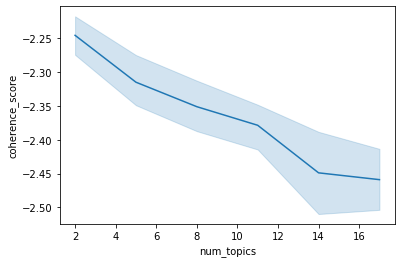

In [154]:
# shoe line plot num topics vs coherence score.
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [130]:
# show the initial value of lda corpus.
lda[corpus[0]]

[(2, 0.29997543), (6, 0.62123656)]

In [0]:
# set the distro from lda.
distro = [lda[d] for d in corpus]

In [73]:
# show the initial value of distro.
distro[0]

[(2, 0.29539776), (6, 0.6258142)]

In [0]:
# create a function that fills in list with the empty values.
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
# create new dustro from function.    
new_distro = [update(d) for d in distro]

In [159]:
# create a new dataframe with new distro data & titles.
new_df = pd.DataFrame.from_records(new_distro, index=titles)
# set the columns from topics.
new_df.columns = topics
new_df = new_df.reset_index()
# show dataframe by the mean of column name.
new_df.groupby('name').mean()

,amazon use great tablet fire,great tablet good screen use,battery charge cant thank cheap,tablet love great use watch,tablet app good like amazon,love old tablet year buy,battery good package work box,battery great good work buy,light read kindle turn page,great price good work product,good buy christmas far work,battery long brand amazon buy,kid tablet great use buy,easy use read great size,kindle fire love buy new
name,,,,,,,,,,,,,,,
"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",0.043383,0.050698,0.010399,0.053693,0.129574,0.181014,0.019561,0.005863,0.006322,0.116669,0.080889,0.014080,0.070822,0.094728,0.059525
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",0.030406,0.024044,0.023544,0.054754,0.059829,0.318339,0.006021,0.018957,0.015576,0.040469,0.050479,0.008557,0.203600,0.044210,0.040376
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",0.023086,0.015611,0.018877,0.064143,0.060605,0.329625,0.012011,0.015210,0.014916,0.038140,0.058042,0.008331,0.192632,0.036991,0.047788
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",0.068742,0.049696,0.026836,0.089078,0.129312,0.089128,0.010049,0.020879,0.018662,0.098013,0.053559,0.010788,0.057820,0.109903,0.100380
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",0.073408,0.049527,0.029640,0.086883,0.115189,0.076523,0.019053,0.018788,0.021008,0.070099,0.042558,0.019679,0.042072,0.116364,0.159780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kindle PowerFast International Charging Kit (for accelerated charging in over 200 countries),0.054076,0.000000,0.145307,0.000000,0.000000,0.016817,0.000000,0.048945,0.155373,0.000000,0.025744,0.091582,0.013061,0.102159,0.325264
"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Free 3G + Wi-Fi - Includes Special Offers",0.010881,0.021550,0.028480,0.090426,0.063804,0.032107,0.003426,0.042743,0.236941,0.044260,0.012135,0.003426,0.020547,0.225517,0.117533
"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers",0.014533,0.017610,0.015932,0.045133,0.016657,0.015829,0.015162,0.018970,0.336896,0.030323,0.024621,0.014164,0.016968,0.181480,0.181654


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling